In [6]:
import matplotlib.pyplot as plt

import numpy as np
import cv2 as cv
import random
import json
import os
import tensorflow as tf

from tqdm import tqdm
from PIL import Image
from os import PathLike
from datetime import datetime
from typing import Union, Sequence
from cv2.typing import MatLike, Rect
from matplotlib.patches import Rectangle
from keras import Sequential
from keras.optimizers import Adam
from keras.models import load_model
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Rescaling, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from keras.losses import CategoricalCrossentropy, MeanSquaredError
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix
from cv2.ximgproc.segmentation import createSelectiveSearchSegmentation

In [7]:
class Detector():
    def __init__(self) -> None:
        self.data_path = './Data/coco'
        self.images_path = os.path.join(self.data_path, 'images')
        self.annotations_path = os.path.join(self.data_path, 'result.json')
        self.testset_path = './Test'
        self.images_data = None
        self.annotations = None
        self.threshold = 0.5
        self.train_img_size = (100, 100, 3)
        self.max_regions_num = 50
        self.classes = (0, 1)
        self.NMS_max_plate_num = 3
        self.NMS_iou_threshold = 0.1
        self.NMS_scores_threshold = 0.9
        self.classifier = None
        self.regressor = None
        self.classifier_train_history = None
        self.regressor_train_history = None
        self.time = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
        self.checkpoint_filepath = './Checkpoints/{type}/model_{time}/checkpoint.weights.h5'
        self.classifier_checkpoint_filepath = None
        self.regressor_checkpoint_filepath = None
        self.trained_models_path = './Models/{type}/model_{time}.keras'
        self.best_model_path = './Best_model'
        self.figures_path = './Figures'
        self.selective_search = createSelectiveSearchSegmentation()
        self._load_data()

    def _check_data(self) -> bool:
        if not os.path.exists(self.data_path):
            print("[ERROR] Data path: \'{}\' does not exist.".format(self.data_path))
            return False
        elif not os.path.isdir(self.images_path):
            print("[ERROR] Folder \'images\' not found inside \'{}\'".format(self.data_path))
            return False
        elif not os.listdir(self.images_path):
            print("[ERROR] No images found.")
            return False
        elif not os.path.isfile(self.annotations_path):
            print("[ERROR] Annotation file \'result.json\' not found.")
            return False
        else:
            print("[INFO]  Data status: [OK]")
            return True
        
    def _load_data(self) -> None:
        if self._check_data():
            with open(self.annotations_path, 'r') as json_file:
                data = json.load(json_file)
                self.images_data = data['images']
                self.annotations = data['annotations']
                print("[INFO]  Data loaded successfully.")

    def _get_img_full_path(self, img_name : str) -> Union[str, PathLike]:
        path = os.path.join(self.data_path, img_name)
        return path
    
    def _load_image(self, img_path : Union[str, PathLike]) -> MatLike:
        image = np.asarray(Image.open(img_path))
        return image

    def _cast_to_int(self, num : float) -> int:
        if isinstance(num, float) or isinstance(num, np.float32):
            return int(num)
        return (-1)
        
    def _find_ROIs(self, image : MatLike) -> Sequence[Rect]:
        self.selective_search.setBaseImage(image)
        self.selective_search.switchToSelectiveSearchFast()
        ROIs = self.selective_search.process()
        return ROIs

    def _get_bbox_coords(self, bbox : Sequence[int]) -> tuple[int]:
        x, y, w, h = bbox
        return (x, y, x + w, y + h)
    
    def _get_bbox(self, annotation_id : int) -> Union[tuple[int], int]:
        if self.annotations is not None and annotation_id < len(self.annotations):
            bbox = self.annotations[annotation_id]['bbox']
            bbox = tuple(map(self._cast_to_int, bbox))
            if all(map(lambda value: value >= 0, bbox)):
                return bbox
        return (-1)
    
    def _get_IoU(self, bbox : Sequence[int], ROI : Sequence[int]) -> float:
        bbox_x1, bbox_y1, bbox_x2, bbox_y2 = self._get_bbox_coords(bbox)
        ROI_x1, ROI_y1, ROI_x2, ROI_y2 = self._get_bbox_coords(ROI)
        bbox_area = (bbox_x2 - bbox_x1 + 1) * (bbox_y2 - bbox_y1 + 1)
        ROI_area = (ROI_x2 - ROI_x1 + 1) * (ROI_y2 - ROI_y1 + 1)
        overlap_x1 = max(bbox_x1, ROI_x1)
        overlap_y1 = max(bbox_y1, ROI_y1)
        overlap_x2 = min(bbox_x2, ROI_x2)
        overlap_y2 = min(bbox_y2, ROI_y2)
        overlap = max(0, overlap_x2 - overlap_x1 + 1) * max(0, overlap_y2 - overlap_y1 + 1)
        IoU = float(overlap / (bbox_area + ROI_area - overlap))
        return IoU
    
    def _crop_ROI(self, image : np.ndarray, bbox : Sequence[int]) -> MatLike:
        x, y, w, h = bbox
        return image[y : y + h, x : x + w, :]

    def _resize_ROI(self, ROI : np.ndarray) -> MatLike:
        w, h, _ = self.train_img_size
        ROI = cv.resize(ROI, (w, h))
        return ROI
    
    def _init_data_generator(self, valid_split : int = 0.2) -> ImageDataGenerator:
        data_generator = ImageDataGenerator(
            rotation_range = 8,
            width_shift_range = 0.08,
            shear_range = 0.3,
            height_shift_range = 0.08,
            zoom_range = 0.08,
            validation_split = valid_split)
        return data_generator
    
    def _init_checkpoint_callbacks(self, path : Union[str, PathLike], monitor : str, mode : str, time : str = None) -> Union[ModelCheckpoint, PathLike]:
        if time is not None:
            current_time = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
            self.time = time
            path.format(time = current_time)
        checkpoint = ModelCheckpoint(
            filepath = path,
            monitor = monitor,
            save_best_only = True,
            mode = mode,
            save_weights_only = True)
        return (checkpoint)
    
    def _init_early_stopping(self, patience : int) -> EarlyStopping:
        early_stopping = EarlyStopping(
            monitor = 'val_loss',
            patience = patience,
            verbose = 0,
            mode = 'min')
        return early_stopping
    
    def _generate_classifier(self) -> Sequential:
        adam = Adam(learning_rate = 0.001)
        model = Sequential()
        model.add(Rescaling(
            scale = (1./255),
            input_shape = self.train_img_size))
        model.add(Conv2D(
            filters = 32,
            kernel_size = (3, 3),
            activation = 'relu',
            kernel_initializer = 'he_uniform',
            padding = 'same'))
        model.add(BatchNormalization())
        model.add(Conv2D(
            filters = 32,
            kernel_size = (3, 3),
            activation = 'relu',
            kernel_initializer = 'he_uniform',
            padding = 'same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(
            pool_size = (2, 2)))
        model.add(BatchNormalization())
        model.add(Conv2D(
            filters = 64,
            kernel_size = (3, 3),
            activation = 'relu',
            kernel_initializer = 'he_uniform',
            padding = 'same'))
        model.add(BatchNormalization())
        model.add(Conv2D(
            filters = 64,
            kernel_size = (3, 3),
            activation = 'relu',
            kernel_initializer = 'he_uniform',
            padding = 'same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(
            pool_size = (2, 2)))
        model.add(BatchNormalization())
        model.add(Flatten())
        model.add(Dense(
            units = 128,
            activation = 'relu',
            kernel_initializer = 'he_uniform'))
        model.add(BatchNormalization())
        model.add(Dropout(
            rate = 0.4))
        model.add(Dense(
            units = 256,
            activation = 'relu',
            kernel_initializer = 'he_uniform'))
        model.add(BatchNormalization())
        model.add(Dropout(
            rate = 0.4))
        model.add(Dense(
            units = len(self.classes),
            activation = 'softmax'))
        model.compile(
            optimizer = adam,
            loss = CategoricalCrossentropy(),
            metrics = ['accuracy'])
        return model
    
    def _generate_regressor(self) -> Sequential:
        adam = Adam(learning_rate = 0.001)
        model = Sequential()
        model.add(Dense(
            units = 4,
            activation = 'linear',
            kernel_initializer = 'random_normal'))
        model.add(Dense(
            units = 4,
            activation = 'linear',
            kernel_initializer = 'random_normal'))
        model.compile(
            optimizer = adam,
            loss = MeanSquaredError(),
            metrics = ['mse'])
        return model
    
    def _get_categorical_labels(self, labels : np.ndarray) -> np.ndarray:
        return to_categorical(labels, len(np.unique(labels)))
    
    def _update_best_model(self):
        pass

    def get_train_data(self) -> Union[tuple[MatLike], None]:
        if self.images_data is None or self.annotations is None:
            print("[ERROR] Data could not be loaded.")
            return None
        print("[INFO]  Preparing dataset.")
        classifier_train_data = []
        classifier_train_labels = []
        regressor_train_data = []
        regressor_train_labels = []
        img_id = None
        for annotation in tqdm(self.annotations):
            annotation_id = annotation['id']
            bbox = self._get_bbox(annotation_id)
            if annotation['image_id'] != img_id:
                img_id = annotation['image_id']
                assert img_id == self.images_data[img_id]['id'], "Invalid image id"
                img_name = self.images_data[img_id]['file_name']
                img_path = self._get_img_full_path(img_name)
                img = self._load_image(img_path)
                ROIs = self._find_ROIs(img)
                ROIs_ids = random.sample(range(0, len(ROIs)), self.max_regions_num)
            if isinstance(bbox, tuple):
                for ROI_id, ROI in enumerate(ROIs):
                    IoU = self._get_IoU(bbox, ROI)
                    cropped_ROI = self._crop_ROI(img, ROI)
                    resized_ROI = self._resize_ROI(cropped_ROI)
                    if IoU > self.threshold:
                        classifier_train_data.append(resized_ROI)
                        classifier_train_labels.append(1)
                        regressor_train_data.append(self._get_bbox_coords(ROI))
                        regressor_train_labels.append(self._get_bbox_coords(bbox))
                    elif ROI_id in ROIs_ids:
                        classifier_train_data.append(resized_ROI)
                        classifier_train_labels.append(0)
        X_img = np.array(classifier_train_data)
        Y_img = np.array(classifier_train_labels)
        X_bbox = np.array(regressor_train_data)
        Y_bbox = np.array(regressor_train_labels)
        print('[INFO]  Classifier train data shape:   ', X_img.shape)
        print('[INFO]  Classifier train labels shape: ', Y_img.shape)
        print('[INFO]  Regressor  train data shape:   ', X_bbox.shape)
        print('[INFO]  Regressor  train labels shape: ', Y_bbox.shape)
        return (X_img, Y_img), (X_bbox, Y_bbox)
    
    def train_model(self, batch_size : int = 32, valid_split : int = 0.2, verbose : int = 1) -> None:
        (X_img, Y_img), (X_bbox, Y_bbox) = self.get_train_data()
        Y_img = self._get_categorical_labels(Y_img)
        img_num = np.shape(X_img)[0]
        labels_num = np.shape(Y_img)[0]
        bbox_proposals_num = np.shape(X_bbox)[0]
        bbox_groud_truth_num = np.shape(Y_bbox)[0]
        assert img_num == labels_num, "[ERROR] Number of images and it's labels does not match"
        assert bbox_proposals_num == bbox_groud_truth_num, "[ERROR] Number of bbox proposals and ground truth does not match"
        data_generator = self._init_data_generator()
        self.classifier_checkpoint_filepath = self.checkpoint_filepath.format(type = 'Classifier', time = self.time)
        self.regressor_checkpoint_filepath = self.checkpoint_filepath.format(type = 'Regressor', time = self.time)
        classifier_checkpoint = self._init_checkpoint_callbacks(path = self.classifier_checkpoint_filepath, monitor = 'val_accuracy', mode = 'max')
        regressor_checkpoint = self._init_checkpoint_callbacks(path = self.regressor_checkpoint_filepath, monitor = 'val_mse', mode = 'min')
        classifier_early_stopping = self._init_early_stopping(patience = 10)
        regressor_early_stopping = self._init_early_stopping(patience = 25)
        classifier_train_generator = data_generator.flow(
            x = X_img,
            y = Y_img,
            batch_size = batch_size,
            subset = 'training')
        calssifier_valid_generator = data_generator.flow(
            x = X_img,
            y = Y_img,
            batch_size = batch_size,
            subset = 'validation')
        classifier = self._generate_classifier()
        classifier_training_steps = img_num * (1 - valid_split) // batch_size
        classifier_validation_steps = img_num * valid_split // batch_size
        classifier_save_path = self.trained_models_path.format(type = 'Classifier', time = self.time)
        regressor = self._generate_regressor()
        regressor_save_path = self.trained_models_path.format(type = 'Regressor', time = self.time)
        print("[INFO]  Starting classifier training.")
        self.classifier_train_history = classifier.fit(
            classifier_train_generator,
            epochs = 25,
            steps_per_epoch = classifier_training_steps,
            validation_data = calssifier_valid_generator,
            validation_steps = classifier_validation_steps,
            verbose = verbose,
            callbacks = [classifier_early_stopping, classifier_checkpoint])
        print("[INFO]  Classifier training finished.")
        print("[INFO]  Loading classifier best weights.")
        classifier.load_weights(self.classifier_checkpoint_filepath)
        print("[INFO]  Classifier weights loaded successfully.")
        print("[INFO]  Saving trained classifier...")
        classifier.save(classifier_save_path)
        print("[INFO]  Classifier saved successfully.")
        self.classifier = classifier
        print("[INFO]  Starting regressor training.")
        self.regressor_train_history = regressor.fit(
            x = X_bbox,
            y = Y_bbox,
            epochs = 200,
            validation_split = valid_split,
            verbose = verbose,
            callbacks = [regressor_early_stopping, regressor_checkpoint])
        print("[INFO]  Regressor training finished.")
        print("[INFO]  Loading classifier best weights.")
        regressor.load_weights(self.regressor_checkpoint_filepath)
        print("[INFO]  Regressor weights loaded successfully.")
        print("[INFO]  Saving trained regressor...")
        regressor.save(regressor_save_path)
        print("[INFO]  Regressor saved successfully.")
        self.regressor = regressor

    def plot_train_history(self, history : dict, monitor : str, suptitle : str = None, show_plot : bool = False) -> None:
        if monitor.lower() == 'mse':
            model_type = 'Regressor'
        elif monitor.lower() == 'accuracy':
            model_type = 'Classifier'
        else:
            print('[ERROR] invalid monitor name')
            return
        figure_name = '{type}_model_{time}.png'.format(type = model_type, time = self.time)
        path = os.path.join(self.figures_path, figure_name)
        train_acc = history['{}'.format(monitor.lower())]
        valid_acc = history['val_{}'.format(monitor.lower())]
        train_loss = history['loss']
        valid_loss = history['val_loss']
        train = [train_acc, train_loss]
        valid = [valid_acc, valid_loss]
        y_labels = ['{}'.format(monitor), 'Loss']
        legend = ['Train dataset', 'Validation dataset']
        epochs = [i + 1 for i in range(len(train_acc))]
        if len(train_acc) < 10:
            x_ticks = [i for i in epochs]
        else:
            if len(train_acc) % 2 == 0:
                x_ticks = [i for i in epochs if i % 2 == 0]
                x_ticks.insert(0, 1)
            else:
                x_ticks = [i for i in epochs if i % 2 != 0]
        for i in range(2):
            plt.subplot(2, 1, i + 1)
            plt.suptitle(suptitle)
            plt.plot(epochs, train[i])
            plt.plot(epochs, valid[i])
            plt.xticks(x_ticks)
            plt.xlabel('Epoch')
            plt.ylabel(y_labels[i])
            plt.legend(legend)
            plt.subplots_adjust(hspace = 0.5)
        if not os.path.exists(self.figures_path):
            os.makedirs(self.figures_path)
        plt.savefig(path)
        if show_plot:
            plt.show()

    def validate_model(self) -> None:
        if not os.path.exists(self.testset_path):
            print('[ERROR] Testset folder does not exist.')
            return
        elif not os.listdir(self.testset_path):
            print('[ERROR] No images found to test the model.')
            return
        elif self.classifier is None:
            print('[ERROR] Classiffier was not loaded.')
            return
        elif self.regressor is None:
            print('[ERROR] Regressor was not loaded.')
            return
        classifier_test_data = []
        img_name = random.choice(os.listdir(self.testset_path))
        img_path = os.path.join(self.testset_path, img_name)
        img = self._load_image(img_path)
        ROIs = self._find_ROIs(img)
        for ROI in ROIs:
            cropped_ROI = self._crop_ROI(img, ROI)
            resized_ROI = self._resize_ROI(cropped_ROI)
            classifier_test_data.append(resized_ROI)
        X_test = np.array(classifier_test_data)
        predictions = self.classifier.predict(X_test)
        predictions = tf.math.argmax(predictions, axis = 1)
        scores = []
        bboxes = []
        for i, pred in enumerate(predictions):
            if bool(pred):
                scores.append(predictions[i])
                bboxes.append(ROIs[i])
        bboxes_coords = np.array(list(map(self._get_bbox_coords, bboxes)))
        predicted_coords = self.regressor.predict(bboxes_coords)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.imshow(img)
        NMS = tf.image.non_max_suppression(
            boxes = predicted_coords,
            scores = scores,
            max_output_size = self.NMS_max_plate_num,
            iou_threshold = self.NMS_iou_threshold,
            score_threshold = self.NMS_scores_threshold)
        selected_boxes = [predicted_coords[bbox_id] for bbox_id in NMS]
        for coords in selected_boxes:    
            x1, y1, x2, y2 = coords
            w = abs(x1 - x2)
            h = abs(y1 - y2)
            x = min([x1, x2])
            y = min([y1, y2])
            bbox = Rectangle(
                xy = (x, y),
                width = w,
                height = h,
                linewidth = 1,
                edgecolor = 'r',
                facecolor = 'none')
            ax.add_patch(bbox)
        plt.title('Random test image')
        plt.show()

    def find_plates(self, image : MatLike = None):
        if image is None:
            print('[ERROR] No image provided.')
            return
        elif self.classifier is None:
            print('[ERROR] Classiffier was not loaded.')
            return
        elif self.regressor is None:
            print('[ERROR] Regressor was not loaded.')
            return
        ROIs = self._find_ROIs(image)
        classifier_data = []
        for ROI in ROIs:
            cropped_ROI = self._crop_ROI(image, ROI)
            resized_ROI = self._resize_ROI(cropped_ROI)
            classifier_data.append(resized_ROI)
        X_test = np.array(classifier_data)
        predictions = self.classifier.predict(X_test)
        predictions = tf.math.argmax(predictions, axis = 1)
        scores = []
        bboxes = []
        for i, pred in enumerate(predictions):
            if bool(pred):
                scores.append(predictions[i])
                bboxes.append(ROIs[i])
        bboxes_coords = np.array(list(map(self._get_bbox_coords, bboxes)))
        predicted_coords = self.regressor.predict(bboxes_coords)
        NMS = tf.image.non_max_suppression(
            boxes = predicted_coords,
            scores = scores,
            max_output_size = self.NMS_max_plate_num,
            iou_threshold = self.NMS_iou_threshold,
            score_threshold = self.NMS_scores_threshold)
        selected_boxes = [predicted_coords[bbox_id] for bbox_id in NMS]
        cropped_plates = []
        for selected_box in selected_boxes:
            selected_box = tuple(map(self._cast_to_int, selected_box))
            x1, y1, x2, y2 = selected_box
            cropped_plates.append(image[y1 : y2, x1 : x2, :])
        return cropped_plates

    def load_models(self, path : Union[str, PathLike]  = None) -> None:
        if path is not None and os.path.exists(path):
            self.model = load_model(path)
            print('[INFO]  Provided model has been loaded successfully.')
        elif os.path.exists(self.best_model_path) and os.listdir(self.best_model_path):
            dirs = os.listdir(self.best_model_path)
            classifier_dir = 'Classifier'
            regressor_dir = 'Regressor'
            if 'Classifier' in dirs:
                model_name = os.listdir(os.path.join(self.best_model_path, classifier_dir))[0]
                path = os.path.join(self.best_model_path, classifier_dir, model_name)
                self.classifier = load_model(path)
                print('[INFO]  Classifier has been loaded successfully.')
            else:
                print('[ERROR] Folder \'Classifier\' not found.')
            if 'Regressor' in dirs:
                model_name = os.listdir(os.path.join(self.best_model_path, regressor_dir))[0]
                path = os.path.join(self.best_model_path, regressor_dir, model_name)
                self.regressor = load_model(path)
                print('[INFO]  Regressor has been loaded successfully.')
            else:
                print('[ERROR] Folder \'Regressor\' not found.')
        else:
            print('[ERROR] No model has been loaded.')

    def show_random_img(self) -> None:
        if self.images_data is None or self.annotations is None:
            print('[ERROR] No data to display.')
            return None
        img_id = np.random.randint(0, len(self.images_data))
        img_path = self.images_data[img_id]['file_name']
        img_path = os.path.join(self.data_path, img_path)
        img = np.asarray(Image.open(img_path))
        x, y, w, h = self.annotations[img_id]['bbox']
        bbox = Rectangle(
            xy = (x, y),
            width = w,
            height = h,
            linewidth = 1,
            edgecolor = 'r',
            facecolor = 'none')
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.imshow(img)
        ax.add_patch(bbox)
        plt.title('Random image from dataset')
        plt.show()

# ŁADOWANIE MODELU

In [8]:
detector = Detector()
detector.load_models()

[INFO]  Data status: [OK]
[INFO]  Data loaded successfully.


ValueError: File format not supported: filepath=./Best_model/Classifier/model_07-05-2024_13-16-25. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(./Best_model/Classifier/model_07-05-2024_13-16-25, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

# DETEKCJA TABLICY

1/1 [==============================] - 0s 53ms/step


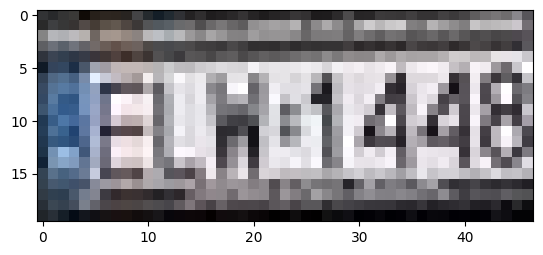

In [5]:
img_name = random.choice(os.listdir(detector.testset_path))
img_path = os.path.join(detector.testset_path, img_name)
img = detector._load_image(img_path)
plates = detector.find_plates(img)
plt.figure()
plt.imshow(plates[0])
plt.show()

# SPRAWDZENIE CZY METODY DZIAŁAJĄ
get_train_data() razcej nie używać.

validate_model() można uruchamiać tylko napierw trzeba wczytać model.

In [ ]:
detector = Detector()

In [6]:
(X_img, Y_img), (X_bbox, Y_bbox) = detector.get_train_data()

100%|██████████| 313/313 [02:27<00:00,  2.13it/s]


Classifier train data shape:    (17182, 100, 100, 3)
Classifier train labels shape:  (17182,)
Regressor train data shape:     (1641, 4)
Regressor train labels shape:   (1641, 4)


In [19]:
detector.load_models()

[INFO]  Classifier has been loaded successfully.
[INFO]  Regressor has been loaded successfully.


1/1 [==============================] - 0s 22ms/step


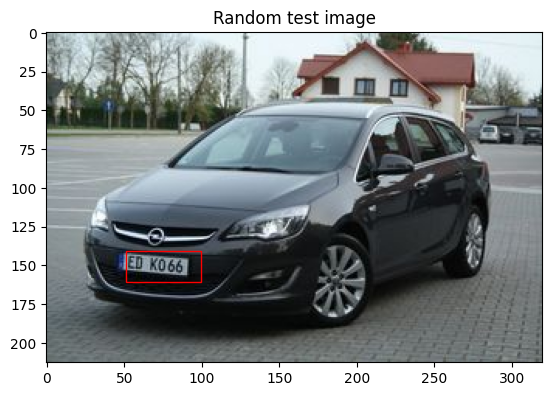

In [26]:
detector.validate_model()

# TRENOWANIE MODELU
train_model() wykorzystuje get_train_data()

In [9]:
detector = Detector()

[INFO]  Data status: [OK]
[INFO]  Data loaded successfully.


In [11]:
detector.train_model()

[INFO]  Preparing dataset.


100%|██████████| 313/313 [03:21<00:00,  1.55it/s]


[INFO]  Classifier train data shape:    (17170, 100, 100, 3)
[INFO]  Classifier train labels shape:  (17170,)
[INFO]  Regressor  train data shape:    (1641, 4)
[INFO]  Regressor  train labels shape:  (1641, 4)


ValueError: When using `save_weights_only=True` in `ModelCheckpoint`, the filepath provided must end in `.weights.h5` (Keras weights format). Received: filepath=./Checkpoints/Classifier/model_27-05-2024_10-08-12/checkpoint

In [ ]:
detector.plot_train_history(detector.classifier_train_history.history, monitor = 'Accuracy', suptitle = 'Classifier accuracy and loss change', show_plot = True)

In [ ]:
detector.plot_train_history(detector.regressor_train_history.history, monitor = 'MSE', suptitle = 'Regressor MSE and loss change', show_plot = True)

1/1 [==============================] - 0s 29ms/step


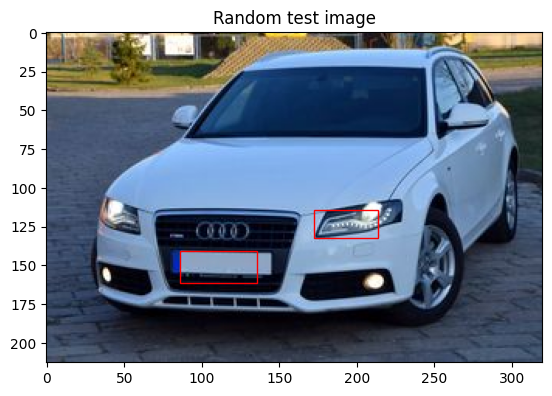

In [24]:
detector.validate_model()